<a href="https://colab.research.google.com/github/b4rthm/lhcb/blob/master/segmentation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
drive_path = "/content/gdrive/My Drive/"

!ls "/content/gdrive/My Drive"
#!ls "/content/gdrive/My Drive/data/Unreal"
#!ls "/content/gdrive/My Drive/Colab Notebooks"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'Colab Notebooks'  'Getting started.pdf'   model_state_dict.pt
 data		   'Maschinelles Lernen'


In [53]:
import os
import random
from skimage import io, transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as T
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

print('CUDA is available:', torch.cuda.is_available())

CUDA is available: True


**Dataset**

In [0]:
# Unreal Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
validate = False  # to set Hyperparameter
val_percentage = 0.1

current_epoch = 0
epochs = 100
lr = 0.001

img_size = 128
num_classes = 6  # 0: background 1:ball 2:crossing 3:goalpost 4:FieldRobot 2:fieldmarkings  
weight = torch.ones(num_classes).to(device)
# weight[0] = 0
weight = weight.float()

dataset_root = drive_path + 'data/Unreal/'


class ToTensor(object):
    def __call__(self, sample):
        img, mask = sample['img'], sample['mask']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img = img.transpose((2, 0, 1))
        return {'img': torch.from_numpy(img).float(), 'mask': torch.from_numpy(mask).unsqueeze(0)}

class Relabel(object):
    def __call__(self, sample):
        mask = sample['mask']
        labels = np.unique(mask)
        
         # background is labeled as 0
        robots = [2,3,4,5,6,7,8,9,10]
        penalty = [27,28]
        circle = [11,12,29,47]
        goal = [56,57,58,59]

        for label in labels:
          if label != 0 and label != 1:  
            # ball is labeled as 1 already
            if label in robots: mask[mask == label] = 2
            elif label in goal: mask[mask == label] = 3
            elif label in penalty: mask[mask == label] = 4
            elif label in circle: mask[mask == label] = 5
            else: mask[mask == label] = 5
        return {'img': sample['img'], 'mask': sample['mask']}

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        img, mask = sample['img'], sample['mask']

        # h, w = img.shape[:2] # numpy
        h, w = img.shape[1:3] # torch
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        img = F.interpolate(img.float().unsqueeze(0), (new_h, new_w)).squeeze(0)
        mask = F.interpolate(mask.float().unsqueeze(0), (new_h, new_w)).squeeze(0)
        return {'img': img, 'mask': mask.long()}


class RandomFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self,sample):
        img, mask = sample['img'], sample['mask']

        if random.random() < self.prob:
            img = torch.flip(img, [2])
            mask = torch.flip(mask, [2])
        return {'img': img, 'mask': mask}


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        img, mask = sample['img'], sample['mask']

        h, w = img.shape[1:3]
        new_h, new_w = self.output_size

        if new_h == h: 
            top = 0
        else:
            top = np.random.randint(0, h - new_h)
        
        if new_w == w:
            left = 0
        else:
            left = np.random.randint(0, w - new_w)

        img = img[:,top: top + new_h, left: left + new_w]
        mask = mask[:,top: top + new_h, left: left + new_w]
        return {'img': img, 'mask': mask}


class UnrealDataset(Dataset):
    def __init__(self, mask_dir, img_dir, transform=None):
        self.mask_dir = mask_dir
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        img_name = 'ScreenShot'
        if idx < 10: img_name += '0000' 
        elif idx < 100: img_name += '000'
        elif idx < 1000: img_name += '00'
        elif idx < 10000: img_name += '0'
        
        img_name += str(idx) + '.png'
        img_path = os.path.join(self.img_dir, img_name)
        img = io.imread(img_path)[:,:,:3]  # removing alpha channel

        mask_name = 'mask' + str(idx) + '.txt'
        mask_path = os.path.join(self.mask_dir, mask_name) 
        mask = np.loadtxt(fname = mask_path)

        sample = {'img': img, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample['img'], sample['mask']


transforms = T.Compose([
                        ToTensor(),
                        Relabel(),
                        Rescale((140,140)),
                        RandomFlip(0.5),
                        RandomCrop((128,128)),
                        ])

dataset = UnrealDataset(dataset_root + 'ScreenshotMasks/', dataset_root + 'Screenshots/', transforms)

train_dataset = Subset(dataset, range(0,800))
test_dataset = Subset(dataset, range(800,1000))

val_dataset = Subset(train_dataset, range(0, len(train_dataset), int( 1 / val_percentage))) # sample with step_size = (1 / val_percentage)
small_test_dataset = Subset(test_dataset, range(0, len(test_dataset), int( 1 / val_percentage)))

def show_image_tensor(img):
    img = img.long()
    plt.imshow(img.transpose(0,2).transpose(0,1)); plt.show()

def show_mask_tensor(mask):
    plt.imshow(mask[0]); plt.show()

**Dataset Demo**

Image Shape torch.Size([3, 128, 128])
Mask Shape torch.Size([1, 128, 128])
Containing Labels: [0 2 3 5]


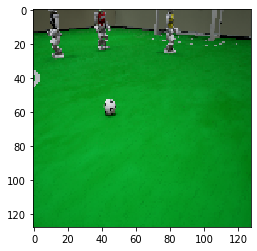

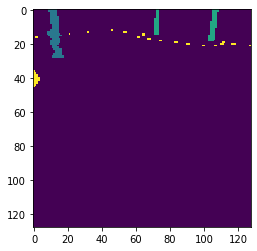

In [54]:
img, mask = dataset[16]
print('Image Shape', img.shape)
print('Mask Shape', mask.shape)
print('Containing Labels:', np.unique(mask))

show_image_tensor(img)
show_mask_tensor(mask)

**Data Loader**




In [0]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=6) # shuffle=True necessary for show_segmentation

if validate:
    train_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=6)
    test_loader = DataLoader(small_test_dataset, batch_size, shuffle=True, num_workers=6)

**Model**

In [0]:
class Conv3x3(nn.Module):
    """ Conv => BN => ReLU """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv3x3(x)


class Down(nn.Module):
    """ Downscaling with maxpool/conv then conv """

    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        if pooling:
            self.down = nn.Sequential(
                nn.MaxPool2d(2),
                Conv3x3(in_channels, out_channels)
            )
        else:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                Conv3x3(out_channels, out_channels)    
            )
    def forward(self, x):
        return self.down(x)


class Up(nn.Module):
    """ Upscaling then conv """

    def __init__(self, in_channels, out_channels,  bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.conv = Conv3x3(in_channels + out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # print(x1.shape, x2.shape)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, channels, n_classes, pooling=True, bilinear=True):
        super(UNet, self).__init__()

        self.inc = Conv3x3(channels[0], channels[1])
        self.down1 = Down(channels[1], channels[2] ,pooling)
        self.down2 = Down(channels[2], channels[3] ,pooling)
        self.down3 = Down(channels[3], channels[4] ,pooling)
        self.down4 = Down(channels[4], channels[5] ,pooling)
        self.up1 = Up(channels[5], channels[4],  bilinear)
        self.up2 = Up(channels[4], channels[3], bilinear)
        self.up3 = Up(channels[3], channels[2], bilinear)
        self.up4 = Up(channels[2], channels[1], bilinear)
        self.outc = OutConv(channels[1], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


#channels = [3,32,48,64,80,96]
#channels = [3,16,32,48,64,80]
channels = [3,16,24,32,40,48]


model = UNet(channels, num_classes).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

**Inference Time**

In [59]:
data_iter = iter(test_dataset)
data_sample = next(data_iter)

%time model.cpu()(data_sample[0].unsqueeze(0))

model = model.to(device)


CPU times: user 38.8 ms, sys: 177 µs, total: 39 ms
Wall time: 21.4 ms


In [0]:
def train(loader):
    model.train()
    total_loss = 0
    i = 0
    for data, label in loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, label[:, 0], weight)  # Calculate Loss (batchwise mean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        i += 1
        if i % 10 == 0:
            print(i * batch_size, '/', len(loader.dataset))
    return total_loss / len(loader.dataset)


def test(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            label = label.to(device)
            pred = model(data)
            loss = criterion(pred, label[:, 0], weight)
            total_loss += loss.item() * data.size(0)
    return total_loss / len(loader.dataset)


def criterion(pred, label, weight):
    return F.cross_entropy(pred, label, weight)


def decode_segmap(img, nc=22):
    label_colors = np.array([(0, 0, 0),  # 0=background
                             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                             (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
                             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                             (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
                             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                             (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
                             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor, 21=boarder
                             (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128), (255,255,255)])

    r = np.zeros_like(img).astype(np.uint8)
    g = np.zeros_like(img).astype(np.uint8)
    b = np.zeros_like(img).astype(np.uint8)

    for l in range(0, nc):
        idx = img == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


def normalize_img(img):
    img -= np.min(img)
    img /= np.max(img)
    return img
    

def show_segmetation(iterator, ammount = 1):
 model.eval()
 with torch.no_grad():
    while ammount > 0:
        data, label = next(iterator)
        data = data.to(device)
        #print(data.shape)
        pred = model(data).cpu()
        #print(pred.shape)
        # for every image in batch, show segmentation
        for i in range(pred.size(0)):
            #print(pred[i].shape)
            pred_i = torch.argmax(pred[i], dim=0).detach().numpy()
            #print(pred_i.shape)
            label_i = label[i].squeeze()
            rgb_seg = decode_segmap(pred_i)
            rgb_seg_label = decode_segmap(label_i)
            data_i = data[i].permute(1, 2, 0).cpu().numpy()

            f, axarr = plt.subplots(1,3)
            f.set_dpi(150)

            axarr[0].imshow(normalize_img(data_i))
            axarr[1].imshow(rgb_seg_label)
            axarr[2].imshow(rgb_seg)
            plt.show()
            
            ammount -= 1
            if ammount <= 0: break


**Live Demo**

In [0]:
print('\nTrain Segmentation')
show_segmetation(iter(train_loader), 1)

print('\nTest Segmentation')
show_segmetation(iter(test_loader), 1)

**Train Loop**

640 / 800

Epoch 1 Train Loss: 1.548694887161255
Epoch 1 Test Loss: 1.425601930618286

Train Segmentation


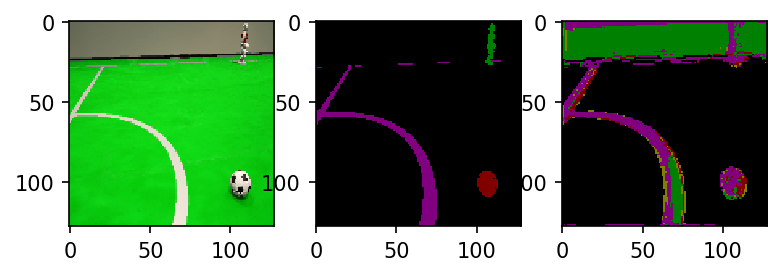

In [0]:
for epoch in range(100):
        current_epoch += 1

        train_loss = train(train_loader)
        print('\nEpoch', current_epoch, 'Train Loss:', train_loss)

        test_loss = test(test_loader)
        print('Epoch', current_epoch, 'Test Loss:', test_loss)

        print('\nTrain Segmentation')
        show_segmetation(iter(train_loader), 1)

        print('\nTest Segmentation')
        show_segmetation(iter(test_loader), 1)

PATH_SAVE = drive_path +  'model_state_dict.pt'
torch.save(model.state_dict(), PATH_SAVE)

**Test Image from URL**

In [0]:
from PIL import Image
 
!wget -nv https://1.bp.blogspot.com/-jahMvf_VQfo/WQ7uhhgzGII/AAAAAAAARVI/GU4tq4RQ4XMaOJPPQSm3oLlYRUAXWikfgCLcB/s1600/J19A9135.JPG -O naos.png
img = Image.open('./naos.png')

img = T.Resize((128,128))(img)

plt.imshow(img); plt.show()

img = T.ToTensor()(img)
img = img.unsqueeze(0)
img = img.to(device)

pred = model(img)
pred = torch.argmax(pred[0], dim=0).detach().cpu().numpy()
pred = decode_segmap(pred)

plt.imshow(pred); plt.show()

**Save Model**

In [0]:
PATH_SAVE = drive_path +  'model_state_dict.pt'
torch.save(model.state_dict(), PATH_SAVE)

**Load Model**

In [0]:
PATH_LOAD = drive_path + 'model_state_dict.pt'
model = UNet(3, num_classes).to(device)
model.load_state_dict(torch.load(PATH_LOAD))

**Parameter Count**

In [14]:
def countNonZeroWeights(model):
    non_zeros = 0
    for param in model.parameters():
        if param is not None:
            non_zeros += torch.sum((param != 0))
    return non_zeros

print('Non Zero Parameters:',  countNonZeroWeights(model).item()) 

Non Zero Parameters: 254774


**Show Labels Seperately**

In [0]:
img_idx = 17

# 0 Hintergrund
# 1 Ball
# 2-10 Roboter
# 27,28 Penalty Cross
# 56,57,58,59 Torpfosten

# 29 Mittelkreis
# 11,12 Schnittpunkt Kreis, Mittellinie

# 13,20 Schnittpunkt Seitenlinie, Mittellinie
# 47 Mittellinie Innen
# 30,35,36 Mittellinie Außen

# 14,31,32,33,34,48,49,50,51,52,53,54,55 Linienstücke
# 37,38 Linie Tor Außen
# 41,42 Linie Torseite
# 15,16,21,26 Eckpunkt
# 19,22,25 Eckpunkt Strafraum
# 17,18,23,24 Schnittpunkt Strafraum linie
# 39,40 Strafraum mitte
# 43,44,45,46 Strafraum links/rechts

img, mask = dataset[img_idx]
print('Image Shape', img.shape)
print('Mask Shape', mask.shape)
print('Containing Labels:', np.unique(mask))

labels = range(1, torch.max(mask).int() + 1)
    
for i in labels:
    if i not in np.unique(mask): continue
    print('Mask Label', i)
    for j in range(1, torch.max(mask).int() + 1):
        if j != i:
            mask[mask == j] = 0
    show_image_tensor(img)
    show_mask_tensor(mask)
    mask = dataset[img_idx][1]

**Show Images with Mask**

In [0]:
a = 5
f, axarr = plt.subplots(1,a)
f.set_dpi(200)

f2, axarr2 = plt.subplots(1,a)
f2.set_dpi(200)

b = 0
count = 0
for i in range(b,b+a):
        img, mask = dataset[i]
        img = img.long()
        axarr[count].imshow(img.transpose(0,2).transpose(0,1))
        axarr[count].axis('off')

        axarr2[count].imshow(mask[0])
        axarr2[count].axis('off')
        count += 1
plt.show()

# Corrupt Images 4, 16, 26, 36, 64

**Model Summary**

In [0]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))